In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
#from config import * 
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.serif'] = 'Computer Modern Roman'


import numpy as np
from glob import glob
import os

import re
from parser import parse_filename, natural_sort
import pandas as pd

from IPython import display
import time
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

import sys, os
sys.path.append("../src")
from checkpoint import find_ckpt_filename, load_data

In [2]:
def get_gr(x, y, L): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
        
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
   
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, L/2], bins=100)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh*rs, hist/h_id

1024 8192


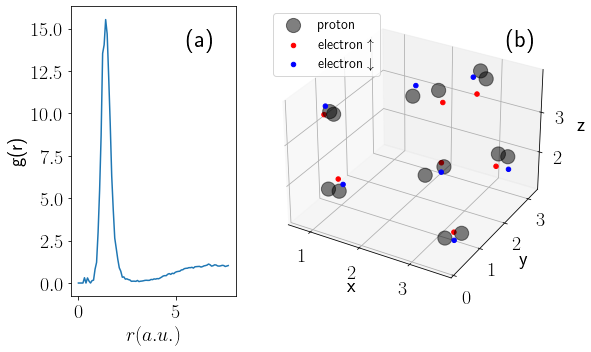

In [5]:
%matplotlib inline
ckpt_file = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist-mala/n_14_dim_3_t_1_rs_4_T_5000_fs_1_fd_4_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.05_lr_0.01_0.01_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1024_bs_8_accsteps_1/epoch_000713.pkl'

n = 14
rs = 4.0 
L = (4/3*jnp.pi*n)**(1/3)
    
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

ax = fig.add_subplot(gs[0])

data = load_data(ckpt_file)
    
s, x = data['s'], data['x']
        
n, dim = x.shape[-2], x.shape[-1]
s = s.reshape(-1, n, dim)
x = x.reshape(-1, n, dim)        
w, b = s.shape[0], x.shape[0]

s = s - L*np.floor(s/L)
x = x - L*np.floor(x/L)

rmesh, gr = get_gr(s, s, L)
ax.plot(rmesh, gr, label=r'$pp, rs=%g, n = %g$'%(rs, n))
ax.set_xlabel('$r(a.u.)$')
ax.set_ylabel('g(r)')

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 

ax = fig.add_subplot(gs[1], projection='3d')

i = 0 # proton batch
ax.scatter(s[i, :, 0], 
           s[i, :, 1], 
           s[i, :, 2], 
           marker='o', color='k', s=200, alpha=0.5, label='proton')

#ax.scatter(x[i*(b//w):(i+1)*(b//w), :n//2, 0], x[i*(b//w):(i+1)*(b//w), :n//2, 1], x[i*(b//w):(i+1)*(b//w), :n//2, 2], marker='o', color='r', s=10)
#ax.scatter(x[i*(b//w):(i+1)*(b//w), n//2:, 0], x[i*(b//w):(i+1)*(b//w), n//2:, 1], x[i*(b//w):(i+1)*(b//w), n//2:, 2], marker='o', color='b', s=10)

j = 0 # electron batch 
assert (j<b//w)
ax.scatter(x[i*(b//w)+j, :n//2, 0], 
           x[i*(b//w)+j, :n//2, 1], 
           x[i*(b//w)+j, :n//2, 2], 
           marker='o', color='r', s=20, alpha=1, label=r'electron $\uparrow$')
ax.scatter(x[i*(b//w)+j, n//2:, 0], 
           x[i*(b//w)+j, n//2:, 1], 
           x[i*(b//w)+j, n//2:, 2], 
           marker='o', color='b', s=20, alpha=1, label=r'electron $\downarrow$')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

at = AnchoredText("(b)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 
ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig('mole.pdf')
print (w,b)

1024 8192


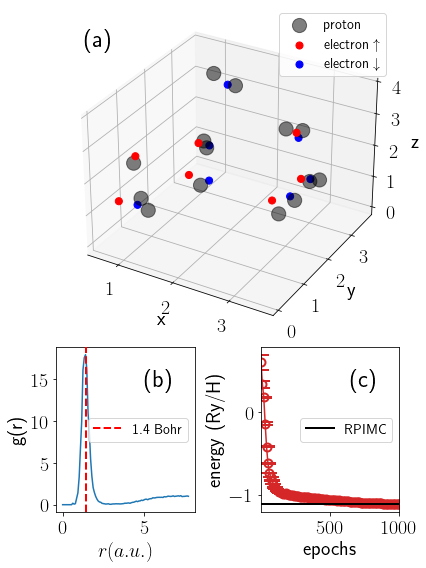

In [10]:
%matplotlib inline

from matplotlib import rcParams
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 14

f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist-mala/n_14_dim_3_t_1_rs_4_T_5000_fs_1_fd_4_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_500_mcwidth_0.01_0.05_lr_0.01_0.01_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_4_alpha_0.05_ws_1024_bs_8_accsteps_1/data.txt'
ckpt_file = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist-mala/n_14_dim_3_t_1_rs_4_T_5000_fs_1_fd_4_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_500_mcwidth_0.01_0.05_lr_0.01_0.01_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_4_alpha_0.05_ws_1024_bs_8_accsteps_1/epoch_000921.pkl'

n = 14
rs = 4.0 
T = 5000
L = (4/3*jnp.pi*n)**(1/3)
    
fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(2,2, height_ratios = [2, 1]) 

############################################
ax = fig.add_subplot(gs[1, 0])
data = load_data(ckpt_file)
    
s, x = data['s'], data['x']
        
n, dim = x.shape[-2], x.shape[-1]
s = s.reshape(-1, n, dim)
x = x.reshape(-1, n, dim)        
w, b = s.shape[0], x.shape[0]

s = s - L*np.floor(s/L)
x = x - L*np.floor(x/L)

rmesh, gr = get_gr(s, s, L)
ax.plot(rmesh, gr)
plt.axvline(x=1.4, color='r', ls='--', lw=2, zorder=99, label='1.4 Bohr')

#if (w != b): s = jnp.repeat(s, b//w, 0)
#rmesh, gr = get_gr(s, x, L)
#ax.plot(rmesh, gr) 

ax.set_xlabel('$r(a.u.)$')
ax.set_ylabel('g(r)')
plt.legend(loc='center right')

at = AnchoredText("(b)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 

############################################
ax = fig.add_subplot(gs[0, :], projection='3d')
i = 1 # proton batch

ax.scatter(s[i, :, 0], 
           s[i, :, 1], 
           s[i, :, 2], 
           marker='o', color='k', s=200, alpha=0.5, label='proton')

if False:
    ax.scatter(x[i*(b//w):(i+1)*(b//w), :n//2, 0], 
               x[i*(b//w):(i+1)*(b//w), :n//2, 1], 
               x[i*(b//w):(i+1)*(b//w), :n//2, 2], 
               marker='o', color='r', s=10, label=r'electron $\uparrow$')
    ax.scatter(x[i*(b//w):(i+1)*(b//w), n//2:, 0], 
               x[i*(b//w):(i+1)*(b//w), n//2:, 1], 
               x[i*(b//w):(i+1)*(b//w), n//2:, 2], 
               marker='o', color='b', s=10, label=r'electron $\downarrow$')
else:
    j = 0 # electron batch 
    assert (j<b//w)
    ax.scatter(x[i*(b//w)+j, :n//2, 0], 
               x[i*(b//w)+j, :n//2, 1], 
               x[i*(b//w)+j, :n//2, 2], 
               marker='o', color='r', s=50, alpha=1, label=r'electron $\uparrow$')
    ax.scatter(x[i*(b//w)+j, n//2:, 0], 
               x[i*(b//w)+j, n//2:, 1], 
               x[i*(b//w)+j, n//2:, 2], 
               marker='o', color='b', s=50, alpha=1, label=r'electron $\downarrow$')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 
ax.legend(loc="upper right")

############################################
ax = fig.add_subplot(gs[1, 1])
Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
df = pd.read_csv(f, delimiter=r"\s+")
y = df['e'].values + df['vpp'].values + Kp 
yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)

SKIP = 10

marker = 'o'
color = 'C3'
plt.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP],
             marker=marker, color=color,markerfacecolor='none', 
             markeredgewidth=2, ms=8, capsize=8)

ref_value = -0.55882*2 # Ry
plt.axhline(y=ref_value, color='k', lw=2, zorder=99, label='RPIMC')

ax.set_ylabel('energy (Ry/H)')
ax.set_xlabel('epochs')
plt.xlim([1, 1000])
plt.legend(loc='center right')

at = AnchoredText("(c)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 
############################################

plt.tight_layout()
plt.savefig('mole.pdf')
print (w,b)

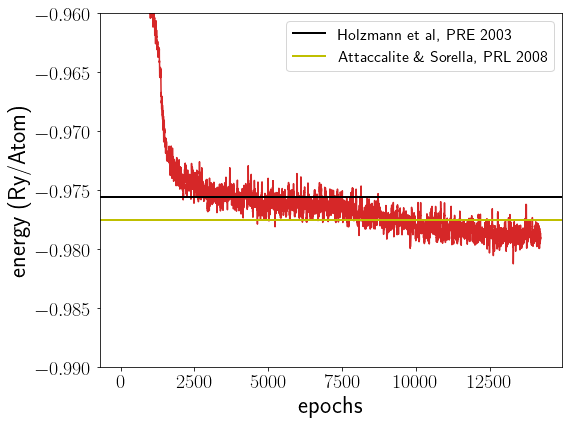

In [6]:
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['legend.fontsize'] = 16

#f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-real/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_5_K_1_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_8192_accsteps_1/data.txt'
f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-real/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_5_K_1_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_4096_accsteps_1/data.txt'

obs = 'etot'
marker = 'o'
color = 'C3'

def plot_subplot(f, ax):
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w, nk, t = parse_filename(f)

    df = pd.read_csv(f, delimiter=r"\s+")

    y = df['e'].values + df['vpp'].values
    yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
  
    #SKIP = 100
    #ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP],
    #             marker=marker, color=color,markerfacecolor='none', 
    #             markeredgewidth=2, ms=2, capsize=8, ls='none', alpha=0.2)
    
    #https://github.com/deepmind/ferminet/blob/main/ferminet/utils/tests/statistics_test.py#L42
    ewm = pd.Series(y).ewm(adjust=False, alpha=0.1)
    y_ewm = ewm.mean(bias=True)
    plt.plot(df['epoch'].values, y_ewm, '-', color=color)

    #plt.xscale('log') 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_subplot(f, ax)#solid

ax.axhline(y=-0.4878*2, color='k', lw = 2, label='Holzmann et al, PRE 2003')
ax.axhline(y=-0.48875*2, color='y', lw = 2, label=r'Attaccalite \& Sorella, PRL 2008')
ax.legend(loc='best')
ax.set_ylim([-0.99, -0.96])
#ax.set_xscale('log') 

ax.set_ylabel('energy (Ry/Atom)')
ax.set_xlabel('epochs')
plt.tight_layout()
plt.savefig('gs.pdf')